In [1]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
import sacc
import os
from scipy.integrate import simps
import yaml

In [2]:
class DataGenerator(object):
    lmax = 5000

    def __init__(self, config):
        self.c = config
        print(self.c['sacc_name'])
        # Read redshift distributions and compute number densities
        # for all redshift bins
        d = np.load(self.c['dNdz_file'])
        self.z_sh = d['z_sh']
        self.nz_sh = d['dNdz_sh'].T
        norms_sh = simps(self.nz_sh, x=self.z_sh)
        self.ndens_sh = self.c['ndens_sh']*norms_sh/np.sum(norms_sh)
        self.ndens_sh *= (180*60/np.pi)**2
        self.n_sh = len(self.ndens_sh)

        # Cosmological model
        if 'cosmology' in self.c:
            self.cosmo = ccl.Cosmology(**(self.c['cosmology']))
        else:
            self.cosmo = ccl.CosmologyVanillaLCDM()
        ccl.sigma8(self.cosmo)
        self.cosmo.compute_nonlin_power()
        self.ll = None

    def _get_covariance(self, cls, unwrap=True):
        """ Generates Gaussian covariance given power spectrum matrix
        """
        nt, _, nl = cls.shape
        ll = self._get_ell_sampling()
        ls = ll['mean']
        dl = ll['d_ell']
        fsky = self.c.get('fsky', 0.4)
        ncl = (nt*(nt+1)) // 2
        cov = np.zeros([ncl, nl, ncl, nl])
        nmodes = fsky*(2*ls+1)*dl
        for i1, i2, icl, ni1, ni2, clit in self._get_indices(nt):
            for j1, j2, jcl, nj1, nj2, cljt in self._get_indices(nt):
                cli1j1 = cls[i1, j1]
                cli1j2 = cls[i1, j2]
                cli2j1 = cls[i2, j1]
                cli2j2 = cls[i2, j2]
                cov[icl, :, jcl, :] = np.diag((cli1j1*cli2j2 +
                                               cli1j2*cli2j1)/nmodes)
        if unwrap:
            cov = cov.reshape([ncl*nl, ncl*nl])
        return cov

    def _get_tracer_name(self, i):
        """ Returns tracer name given its index
        """
        return f'sh{i+1}'

    def _get_cl_type(self, i, j):
        """ Returns power spectrum type given
        tracer indices.
        """
        return 'cl_ee'

    def _get_indices(self, nt):
        """ Iterator through all bin pairs
        """
        icl = 0
        for i1 in range(nt):
            for i2 in range(i1, nt):
                yield (i1, i2, icl,
                       self._get_tracer_name(i1),
                       self._get_tracer_name(i2),
                       self._get_cl_type(i1, i2))
                icl += 1

    def _get_nls(self):
        """ Computes matrix of noise power spectra
        """
        ll = self._get_ell_sampling()
        n_tot = self.n_sh
        nls = np.zeros([n_tot, n_tot, ll['n_bpw']])
        sgamma = self.c.get('e_rms', 0.28)
        for i in range(self.n_sh):
            nls[i, i, :] = sgamma**2/self.ndens_sh[i]
        return nls

    def _get_shear_tracers(self):
        """ Generates all shear tracers
        """
        A_IA = self.c['ia'].get('A_IA', 1.)
        eta_IA = self.c['ia'].get('eta_IA', 0.)
        Az = A_IA*((1+self.z_sh)/1.62)**eta_IA
        return [[ccl.WeakLensingTracer(self.cosmo, (self.z_sh, n)),
                 ccl.WeakLensingTracer(self.cosmo, has_shear=False,
                                       dndz=(self.z_sh, n),
                                       ia_bias=(self.z_sh, Az))]
                for n in self.nz_sh]

    def _get_pks(self):
        pkmm = self.cosmo.get_nonlin_power()
        # 1. Get the values of k and a from pkmm
        # 2. Create arrays of Delta_GI and Delta_II sampled at the same values of k and a
        # 3. Create pkGI and pkGG by multiplying the pkmm array and then regenerating 2 Pk2D objects
        return {'GG': pkmm, 'GI': pkmm, 'II': pkmm}

    def _get_cls(self):
        """ Computes all angular power spectra
        """
        # Get shear tracers
        ts = self._get_shear_tracers()
        # Get P(k)s
        pks = self._get_pks()

        # Ell sampling
        ll = self._get_ell_sampling()
        n_tot = self.n_sh

        # Loop over all tracer pairs
        cls = np.zeros([n_tot, n_tot, ll['n_bpw']])
        for i1, (t1g, t1i) in enumerate(ts):
            for i2, (t2g, t2i) in enumerate(ts):
                if i2 < i1:
                    continue
                # Limber integral
                clgg = ccl.angular_cl(self.cosmo, t1g, t2g, ll['ls'], p_of_k_a=pks['GG'])
                clgi = ccl.angular_cl(self.cosmo, t1g, t2i, ll['ls'], p_of_k_a=pks['GI'])
                clig = ccl.angular_cl(self.cosmo, t1i, t2g, ll['ls'], p_of_k_a=pks['GI'])
                clii = ccl.angular_cl(self.cosmo, t1i, t2i, ll['ls'], p_of_k_a=pks['II'])
                # Bandpower window convolution
                clb = np.dot(ll['bpws'], clgg+clgi+clig+clii)
                cls[i1, i2, :] = clb
                if i1 != i2:
                    cls[i2, i1, :] = clb
        return cls

    def _get_ell_sampling(self):
        """ Defines the ell sampling of the data vector.
        We use linear sampling with separation
        `dl_linear` = 10 up to a given `ell_linear`, and
        then switch to log spacing with `nl_per_decade`=10
        ells per dex. The value of `ell_linear` is such that
        the separation between adjacent ells after
        `ell_linear` using log sampling is larger or equal
        to `d_ell_linear`. We start at ell=2 and stop at
        ell=5000.
        """
        if self.ll is None:
            # First work out the ell edges
            dl_linear = 10
            nl_per_decade = 10
            dlogl = 1./nl_per_decade
            l_edges = [2]
            l_last = l_edges[0]
            while l_last < self.lmax:
                dl_log = l_last*(10**dlogl-1)
                if dl_log < dl_linear:
                    l_last += dl_linear
                else:
                    l_last += dl_log
                l_edges.append(int(l_last))
            l_edges = np.array(l_edges)

            # Compute bandpower window functions.
            # Assumed top-hat weighted by 2*l+1.
            n_bpw = len(l_edges)-1
            l_all = np.arange(l_edges[-1])
            bpw_windows = np.zeros([n_bpw, l_edges[-1]])
            l_mean = np.zeros(n_bpw)
            for i in range(n_bpw):
                nells = l_edges[i+1] - l_edges[i]
                msk = (l_all < l_edges[i+1]) & (l_all >= l_edges[i])
                bpw_windows[i, msk] = 1./nells
                l_mean[i] = np.average(l_all[msk],
                                       weights=2*l_all[msk]+1.)
            self.ll = {'ls': l_all,
                       'n_bpw': n_bpw,
                       'edges': l_edges,
                       'd_ell': np.diff(l_edges),
                       'mean': l_mean,
                       'bpws': bpw_windows}
        return self.ll

    def get_sacc_file(self):
        """ Generates sacc file containing full
        data vector, N(z)s, and covariance matrix.
        """
        import sacc
        s = sacc.Sacc()

        # Tracers
        print("Tracers")
        for i, n in enumerate(self.nz_sh):
            s.add_tracer('NZ', f'sh{i+1}',
                         quantity='galaxy_shear',
                         spin=2, z=self.z_sh, nz=n)

        # Bandpower windows
        print("Windows")
        ll = self._get_ell_sampling()
        wins = sacc.BandpowerWindow(ll['ls'], ll['bpws'].T)

        # Cls
        print("Cls")
        sl = self._get_cls()
        for i1, i2, icl, n1, n2, clt in self._get_indices(self.n_sh):
            s.add_ell_cl(clt, n1, n2, ll['mean'], sl[i1, i2], window=wins)

        # Covariance
        print("Cov")
        nl = self._get_nls()
        cov = self._get_covariance(sl+nl, unwrap=True)
        s.add_covariance(cov)

        if self.c.get('add_noise', False):
            s.mean = np.random.multivariate_normal(s.mean, cov)

        # Save
        print("Write")
        s.save_fits(self.c['sacc_name'], overwrite=True)
        return s

    def save_config(self):
        """ Saves yaml file used to generate these data.
        """
        import yaml

        with open(self.c['sacc_name']+'.yml', 'w') as outfile:
            yaml.dump(self.c, outfile, default_flow_style=False)


In [3]:
with open('test_simple.yml', "r") as fin:
    config = yaml.load(fin, Loader=yaml.FullLoader)

d = DataGenerator(config)
s = d.get_sacc_file()
d.save_config()
print(" ")

test_simple.fits
Tracers
Windows
Cls
Cov
Write
 


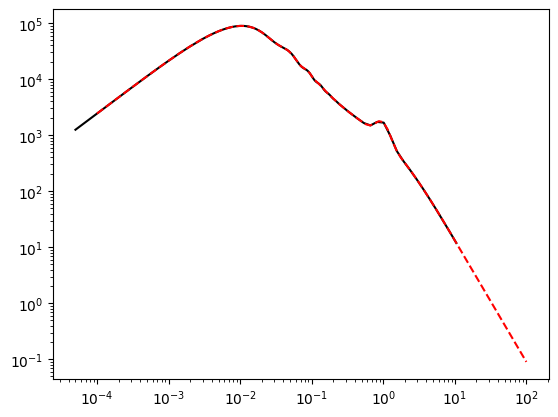

In [4]:
# Example for how to perturb the matter power spectrum
cosmo = ccl.CosmologyVanillaLCDM()
cosmo.compute_nonlin_power()

# Start from here
pkmm = cosmo.get_nonlin_power()
a, logk, pk = pkmm.get_spline_arrays()
delta = np.exp(-0.5*((logk[None, :]-np.log(1.0))/0.2)**2)*a[:, None]
pk_perturbed = pk*(1+delta)
pk_perturbed_reinterp = ccl.Pk2D(a_arr=a, lk_arr=logk, pk_arr=np.log(pk_perturbed))
ks = np.geomspace(1E-4, 1E2, 100)
plt.plot(np.exp(logk), pk_perturbed[-1, :], 'k-')
plt.plot(ks, pk_perturbed_reinterp.eval(ks, 1.0, cosmo), 'r--')
plt.xscale('log')
plt.yscale('log')